Naver Developers 의 Search-기본검색 API를 활용한 크롤링
- "환경부 탄소" 로 크롤링

In [2]:
import requests
import os
from dotenv import load_dotenv
import csv

# .env 파일에서 환경 변수 로드
load_dotenv()

# .env 파일에서 Naver API 인증 정보 가져오기
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# 사용자 입력: 검색 쿼리와 출력 결과 개수 설정
query = "환경부 탄소중립정책"  # Example query for environmental news
display_count = 100 # 출력할 뉴스 개수

# Naver API 뉴스 검색 URL
base_url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display={display_count}"

# API 요청 헤더 
headers = {
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret,
    "Content-Type": "plain/text"
}

    # 뉴스 항목이 있으면 처리 후 CSV에 저장
with open("환경부 탄소 크롤링.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Title", "Link", "Description"])  # CSV 헤더

    # 5 pages 반복 500개 기사(1page당 100개 기사 있음)
    for start in range(1, 501, display_count):
        url = f"{base_url}&start={start}"
        
        response = requests.get(url, headers=headers)

        # 요청이 성공했는지 확인 (HTTP 상태 코드 200)
        if response.status_code == 200:
            news_data = response.json()
            news_items = news_data.get("items", [])  

            if news_items:
                for item in news_items:
                    title = item["title"].replace("<b>", "").replace("</b>", "") 
                    description = item["description"].replace("<b>", "").replace("</b>", "")  
                    link = item["link"]
                    writer.writerow([title, link, description]) 

            else:
                print(f"기사를 찾을 수 없음 : {start}")
        else:
            print(f"에러: {response.status_code} - {response.text}")

print("'환경부 탄소 크롤링.csv'로 저장되었습니다.")


'환경부 탄소 크롤링.csv'로 저장되었습니다.


In [3]:
import pandas as pd
#지역별 발전 설비
df = pd.read_csv('환경부 탄소 크롤링.csv')

print(df)

                                             Title  \
0    KB손해보험, 지수형 특약 및 기후 질환 보장 탑재 'KB해외여행보험' 출시...   
1                    기후위기 특별위원회, 소위원회 구성 및 업무보고 진행   
2                 국회 기후위기특위, 탄소중립법·기후예산 심사 소위원회 구성   
3           [로컬거버넌스] 인천시 계양구, 탄소중립·녹색성장 기본계획 수립 추진   
4             “차기 정부, 기술 중심 혁신과 규제 혁파 체제 갖춰야” 행정학회   
..                                             ...   
495                     [패트롤] 고양시-양주시-의정부시-파주시-하남시   
496           [N2 뷰] 전북특별자치도 탄소소재 중심지인가, 산업단지의 섬인가   
497      [에경 초대석] ‘파리협정 담당’ 최재철 기후변화센터 이사장 “탄소감...   
498         하수도도 기후위기 대응 최전선으로… 오염원인자에 '비용 책임' 묻는다   
499    [임기상 칼럼] 중국산 전기 승합차 독주..현대차·기아의 적극적 대응 필...   

                                                  Link  \
0    http://www.sisaon.co.kr/news/articleView.html?...   
1    https://www.kfenews.co.kr/news/articleView.htm...   
2    http://www.energydaily.co.kr/news/articleView....   
3    https://www.siminilbo.co.kr/news/newsview.php?...   
4    https://n.news.naver.com/mnews/article/030/000...   
.. 

In [5]:
import nltk
# nltk 불용어 리스트 다운로드 (한번만 실행)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gus10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

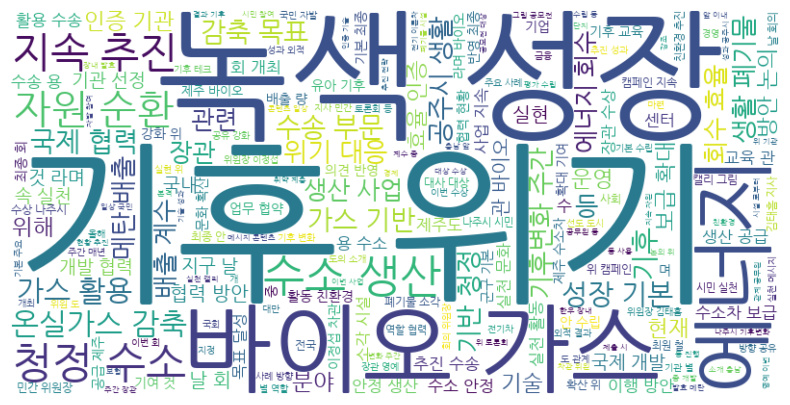

In [62]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Okt
import re

# 한글 폰트 경로 지정
font_path = "C:/Windows/Fonts/NanumGothic.ttf"  

# 쓸모없는 단어 불용어로 차가
additional_stopwords = [
    "뉴스", "중립","탄소", "정책", "산업", "기사", "제목", "기사내용","지원", "한국", "이", "지역",
    "서울", "경기", "대한", "및", "보고", "새로운", "전", "상세", "보도", "계획", "정부",
    "통해", "자료", "발표", "연합뉴스", "중앙", "추가", "환경부", "간담", "환경", "전환", "위원회", "에너지지"
]

okt = Okt()

df = pd.read_csv("환경부 탄소 크롤링.csv", encoding="utf-8")

# 뉴스 제목과 설명을 하나로
text = " ".join(df["Title"].dropna()) + " " + " ".join(df["Description"].dropna())

# 특수 문자 제거 (예: <b>, </b> 태그 및 기타 특수 문자)
text = re.sub(r'<.*?>', '', text)  # HTML 태그 제거
text = re.sub(r'[^A-Za-z0-9가-힣\s]', '', text)  # 특수문자 제거

# 형태소 분석을 통해 명사만 추출
tokens = okt.nouns(text)

# 불용어 제거
filtered_tokens = [word for word in tokens if word not in additional_stopwords]

# 필터링된 단어들을 하나의 텍스트로 결합
filtered_text = " ".join(filtered_tokens)

# 워드 클라우드 생성 
wordcloud = WordCloud(font_path=font_path, stopwords=None, background_color="white", width=800, height=400).generate(filtered_text)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # 축 제거
plt.show()


In [63]:
# 가장 많이 등장한 단어 10개 출력
most_common_words = wordcloud.words_  # 단어 빈도 정보

# 상위 20개 단어 리스트
top_10_words = sorted(most_common_words.items(), key=lambda x: x[1], reverse=True)[:20]

# 출력
for word, freq in top_10_words:
    print(f"{word}: {freq}")

기후 위기: 1.0
녹색 성장: 0.9629629629629629
바이오 가스: 0.9259259259259259
에너지: 0.6790123456790124
수소 생산: 0.654320987654321
청정 수소: 0.6172839506172839
지속 추진: 0.5925925925925926
자원 순환: 0.5432098765432098
온실가스 감축: 0.49382716049382713
기후: 0.4691358024691358
가스 활용: 0.4691358024691358
성장 기본: 0.4444444444444444
감축 목표: 0.41975308641975306
가스 기반: 0.4074074074074074
수송 부문: 0.3950617283950617
국제 협력: 0.38271604938271603
생활 폐기물: 0.35802469135802467
기반 청정: 0.345679012345679
위기 대응: 0.3333333333333333
기후변화 주간: 0.3333333333333333
